# LinkNet 图像语义分割（LinkNet Image Semantic Segmentation）

像素级的图像语义分割（Pixel-level Image Semantic Segmentation）不仅需要精确，还需要高效，以便应用到实时应用（real-time application）中，如自动驾驶、机器人视觉等。

为解决现有方法参数数量大、运算开销高的问题，提出了LinkNet。LinkNet是一种基于编码器-解码器（encoder-decoder）架构的语义分割网络，其编码器部分采用残差网络（ResNet）作为基础网络，解码器部分采用U-Net架构，并引入跳跃连接（skip connection）来保留编码器部分的特征。LinkNet在多个语义分割数据集上取得了较好的性能，同时具有较低的参数数量和运算开销。

![LinkNet.png](./imgs/LinkNet.png) | ![LinkNet-block.png](./imgs/LinkNet-block.png)
--- | ---

## 导入库

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision
from torchvision import transforms
import os

import glob
from PIL import Image

## 数据预处理

In [2]:
# 获取所有数据图片路径
all_pics = glob.glob(r'.\dataset\HK-Portrait\training\*.png')
# 查看数据图片路径
all_pics[:5]

['.\\dataset\\HK-Portrait\\training\\00001.png',
 '.\\dataset\\HK-Portrait\\training\\00001_matte.png',
 '.\\dataset\\HK-Portrait\\training\\00002.png',
 '.\\dataset\\HK-Portrait\\training\\00002_matte.png',
 '.\\dataset\\HK-Portrait\\training\\00003.png']

In [3]:
# 从所有数据图片路径中筛选出数据图片
images = [p for p in all_pics if 'matte' not in p]
# 查看数据图片数量
print("Total images: {}".format(len(images)))
images[:5]

Total images: 1700


['.\\dataset\\HK-Portrait\\training\\00001.png',
 '.\\dataset\\HK-Portrait\\training\\00002.png',
 '.\\dataset\\HK-Portrait\\training\\00003.png',
 '.\\dataset\\HK-Portrait\\training\\00004.png',
 '.\\dataset\\HK-Portrait\\training\\00005.png']

In [4]:
# 从所有数据图片路径中筛选出数据图片的标注
annos = [p for p in all_pics if 'matte' in p]
# 查看数据图片标注数量
print("Total annotations: {}".format(len(annos)))
images[:5]

Total annotations: 1700


['.\\dataset\\HK-Portrait\\training\\00001.png',
 '.\\dataset\\HK-Portrait\\training\\00002.png',
 '.\\dataset\\HK-Portrait\\training\\00003.png',
 '.\\dataset\\HK-Portrait\\training\\00004.png',
 '.\\dataset\\HK-Portrait\\training\\00005.png']

In [5]:
np.random.seed(2021)        # 随机种子，保证每次划分结果一致
random_index = np.random.permutation(len(images))      # 创建与数据集等长的乱序索引random_index
# 对图片使用random_index进行索引
images = np.array(images)[random_index]
# 对标签使用random_index进行索引
annos = np.array(annos)[random_index]
images[:5], annos[:5]

(array(['.\\dataset\\HK-Portrait\\training\\00372.png',
        '.\\dataset\\HK-Portrait\\training\\01290.png',
        '.\\dataset\\HK-Portrait\\training\\00063.png',
        '.\\dataset\\HK-Portrait\\training\\01131.png',
        '.\\dataset\\HK-Portrait\\training\\01126.png'], dtype='<U40'),
 array(['.\\dataset\\HK-Portrait\\training\\00372_matte.png',
        '.\\dataset\\HK-Portrait\\training\\01290_matte.png',
        '.\\dataset\\HK-Portrait\\training\\00063_matte.png',
        '.\\dataset\\HK-Portrait\\training\\01131_matte.png',
        '.\\dataset\\HK-Portrait\\training\\01126_matte.png'], dtype='<U46'))

In [6]:
# 预处理测试集
all_test_pics = glob.glob(r'.\dataset\HK-Portrait\testing\*.png')
test_images = [p for p in all_test_pics if 'matte' not in p]
test_annos = [p for p in all_test_pics if 'matte' in p]

# 创建数据集

In [7]:
# 图片变换
transform = transforms.Compose([
                    transforms.Resize((256, 256)),
                    transforms.ToTensor(),
])

In [8]:
# 自定义数据集类
class Portrait_dataset(data.Dataset):
    def __init__(self, img_paths, anno_paths):
        self.imgs = img_paths
        self.annos = anno_paths
        
    def __getitem__(self, index):
        img = self.imgs[index]
        anno = self.annos[index]
        
        pil_img = Image.open(img)    
        img_tensor = transform(pil_img)
        
        pil_anno = Image.open(anno)    
        anno_tensor = transform(pil_anno)
        anno_tensor = torch.squeeze(anno_tensor).type(torch.long)   # 去掉标注中为1的维度，并将标注转换为long类型
        anno_tensor[anno_tensor > 0] = 1
        
        return img_tensor, anno_tensor
    
    def __len__(self):
        return len(self.imgs)

In [9]:
# 实例化划分后的数据集
train_ds = Portrait_dataset(images, annos)
test_ds = Portrait_dataset(test_images, test_annos)

BATCH_SIZE = 64

train_dl = data.DataLoader(dataset=train_ds,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           pin_memory=True
)
test_dl = data.DataLoader(dataset=test_ds,
                          batch_size=BATCH_SIZE,
                          pin_memory=True)

# 创建 LinkNet 模型

In [10]:
# 卷积模块（卷积 + BN + ReLU）
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, 
                 kernel_size=3, 
                 stride=1, 
                 padding=1):
        super(ConvBlock, self).__init__()
        self.conv_bn_relu = nn.Sequential(
                            nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=padding),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True)
            )
    def forward(self, x):
        x = self.conv_bn_relu(x)
        return x

In [11]:
# 反卷积模块（反卷积 + BN + ReLU）
class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, 
                 kernel_size=3, 
                 stride=2, 
                 padding=1,
                 output_padding=1):
        super(DeconvBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels=in_channels,
                                         out_channels=out_channels,
                                         kernel_size=kernel_size,
                                         stride=stride,
                                         padding=padding,
                                         output_padding=output_padding)
        self.bn = nn.BatchNorm2d(out_channels)
            
    def forward(self, x, is_act=True):
        x = self.deconv(x)
        if is_act:
            x = torch.relu(self.bn(x))
        return x

In [12]:
# 编码器模块（4个卷积模块 + 短接）
class EncodeBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncodeBlock, self).__init__()
        self.conv1_1 = ConvBlock(in_channels, out_channels, stride=2)
        self.conv1_2 = ConvBlock(out_channels, out_channels)
        self.conv2_1 = ConvBlock(out_channels, out_channels)
        self.conv2_2 = ConvBlock(out_channels, out_channels)
        self.shortcut = ConvBlock(in_channels, out_channels, stride=2)

    def forward(self, x):
        out1 = self.conv1_1(x)
        out1 = self.conv2_1(out1)
        residue = self.shortcut(x)
        out2 = self.conv2_1(out1 + residue)
        out2 = self.conv2_2(out2)
        return out2 + out1

In [13]:
# 解码器模块（卷积模块 + 反卷积模块 + 卷积模块）
class DecodeBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecodeBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, in_channels//4,
                               kernel_size=1, padding=0)
        self.deconv = DeconvBlock(in_channels//4, in_channels//4)
        self.conv2 = ConvBlock(in_channels//4, out_channels, 
                               kernel_size=1, padding=0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)
        return x

In [14]:
# LinkNet 模型（编码器 + 解码器 + 卷积模块 + 反卷积模块）
class LinkNet(nn.Module):
    def __init__(self):
        super(LinkNet, self).__init__()
        # Input
        self.input_conv = ConvBlock(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.input_maxpool = nn.MaxPool2d(kernel_size=(2, 2))
        
        # Encoders
        self.encode1 = EncodeBlock(64, 64)
        self.encode2 = EncodeBlock(64, 128)
        self.encode3 = EncodeBlock(128, 256)
        self.encode4 = EncodeBlock(256, 512)
        
        # Decoders
        self.decode4 = DecodeBlock(512, 256)
        self.decode3 = DecodeBlock(256, 128)
        self.decode2 = DecodeBlock(128, 64)
        self.decode1 = DecodeBlock(64, 64)
        
        # Output
        self.output_deconv1 = DeconvBlock(64, 32)
        self.output_conv = ConvBlock(32, 32)
        self.output_deconv2 = DeconvBlock(in_channels=32, out_channels=2, kernel_size=2, padding=0, output_padding=0)
    
    def forward(self, x):                   # [batch, channels, height, width]
        # Input                             # [32, 3, 256, 256]
        x = self.input_conv(x)              # [32, 64, 128, 128]
        x = self.input_maxpool(x)           # [32, 64, 64, 64]
        
        # Encoder
        e1 = self.encode1(x)                # [32, 64, 32, 32]
        e2 = self.encode2(e1)               # [32, 128, 16, 16]
        e3 = self.encode3(e2)               # [32, 256, 8, 8]
        e4 = self.encode4(e3)               # [32, 512, 4, 4]
        
        # Decoder
        d4 = self.decode4(e4)               # [32, 256, 8, 8]
        d3 = self.decode3(d4 + e3)          # [32, 128, 16, 16]
        d2 = self.decode2(d3 + e2)          # [32, 64, 32, 32]
        d1 = self.decode1(d2 + e1)          # [32, 64, 64, 64]
        
        # Output
        y1 = self.output_deconv1(d1)        # [32, 32, 128, 128]
        y2 = self.output_conv(y1)           # [32, 32, 128, 128]
        y3 = self.output_deconv2(y2, is_act=False)      # [32, 2, 256, 256]
        
        return y3

## 模型训练 

In [15]:
# 参数整理
model = LinkNet()
learn_rate = 0.001
epochs = 30
train_dl = train_dl
test_dl = test_dl

# 训练前准备，定义模型、损失函数、优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU，如果有则使用GPU，否则使用CPU
model.to(device) # 将已实例化的模型移动到GPU上

loss_fn = torch.nn.CrossEntropyLoss()  # 损失函数，交叉熵损失函数，使用未激活的输出作为输入，内置了softmax函数为激活函数，输出为每个类别的概率
opt = torch.optim.Adam(model.parameters(), lr=learn_rate) # 优化器，Adam优化器

# 学习率调整器
from torch.optim import lr_scheduler

# # 手动调整学习率
# for param_group in opt.param_groups:
#     print(param_group['lr'])
#     param_group['lr'] *= 0.9

exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1) # 每隔7个epoch，学习率衰减为原来的0.1倍

# lr_scheduler.MultiStepLR(opt, milestones=[5, 10, 15, 20], gamma=0.5) # 每隔5个epoch，学习率衰减为原来的0.1倍
# lr_scheduler.ExponentialLR(opt, gamma=0.5) # 每个epoch，学习率衰减为原来的0.5倍

In [16]:
# 通用训练模板，输入模型、训练数据、测试数据，返回loss，acc和IOU指标变化
# 训练函数
def train(train_dl, model, loss_fn, opt, exp_lr_scheduler):
    size = len(train_dl.dataset) # 获取数据集的大小
    num_batches = len(train_dl) # 获取数据集的批次数量

    train_loss = 0.0 # 训练集损失
    train_acc = 0.0 # 训练集准确率
    train_iou = 0.0 # 训练集IOU指标


    for x, y in train_dl: # 遍历数据集
        x, y = x.to(device), y.to(device) # 将数据移动到GPU上

        pred = model(x) # 前向传播
        loss = loss_fn(pred, y) # 计算损失

        opt.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        opt.step() # 更新参数

        with torch.no_grad(): # 不计算梯度
            pred = pred.argmax(dim=1)   # 获取预测结果
            train_loss += loss.item()   # 计算损失
            train_acc += (pred == y).type(torch.float).sum().item() # 计算准确率

            intersection = torch.logical_and(y, pred)       # 计算交集
            union = torch.logical_or(y, pred)               # 计算并集
            train_iou += torch.true_divide(torch.sum(intersection), torch.sum(union))        # 计算IOU指标

    exp_lr_scheduler.step() # 学习率调整
    train_loss /= num_batches # 计算平均损失
    train_acc /= size*256*256 # 计算平均准确率
    train_iou /= num_batches # 计算平均IOU指标

    return train_loss, train_acc, train_iou

# 测试函数
def test(test_dl, model, loss_fn):
    size = len(test_dl.dataset) # 获取数据集的大小
    num_batches = len(test_dl) # 获取数据集的批次数量

    test_loss = 0.0 # 测试集损失
    test_acc = 0.0 # 测试集准确率
    test_iou = 0.0 # 测试集IOU指标

    with torch.no_grad(): # 不计算梯度
        for x, y in test_dl: # 遍历数据集
            x, y = x.to(device), y.to(device) # 将数据移动到GPU上

            pred = model(x) # 前向传播
            loss = loss_fn(pred, y) # 计算损失
            pred = pred.argmax(dim=1)   # 获取预测结果
            test_loss += loss.item()   # 计算损失
            test_acc += (pred == y).type(torch.float).sum().item() # 计算准确率

            intersection = torch.logical_and(y, pred)       # 计算交集
            union = torch.logical_or(y, pred)               # 计算并集
            test_iou += torch.true_divide(torch.sum(intersection), torch.sum(union))        # 计算IOU指标

    test_loss /= num_batches # 计算平均损失
    test_acc /= size*256*256 # 计算平均准确率
    test_iou /= num_batches # 计算平均IOU指标

    return test_loss, test_acc, test_iou

# 训练函数
def fit(epochs, model, train_dl, test_dl, loss_fn, opt, exp_lr_scheduler):
    train_loss = []
    train_acc = []
    train_iou = []
    test_loss = []
    test_acc = []
    test_iou = []


    print_template = 'Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.2f}%, Train IOU: {:.2f}, Test Loss: {:.4f}, Test Acc: {:.2f}%, Test IOU: {:.2f}'


    for epoch in range(epochs):
        model.train() # 设置模型为训练模式，启用dropout层
        epoch_train_loss, epoch_train_acc, epoch_train_iou= train(train_dl, model, loss_fn, opt, exp_lr_scheduler)
        model.eval() # 设置模型为评估预测模式，禁用dropout层
        epoch_test_loss, epoch_test_acc, epoch_test_iou = test(test_dl, model, loss_fn)

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        train_iou.append(epoch_train_iou)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)
        test_iou.append(epoch_test_iou)

        print(print_template.format(epoch, epoch_train_loss, epoch_train_acc * 100, epoch_train_iou, epoch_test_loss, epoch_test_acc * 100, epoch_test_iou))

    return train_loss, train_acc, train_iou, test_loss, test_acc, test_iou

# 训练
train_loss, train_acc, train_iou, test_loss, test_acc, test_iou = fit(epochs, model, train_dl, test_dl, loss_fn, opt, exp_lr_scheduler)

Epoch: 0, Train Loss: 0.4502, Train Acc: 79.04%, Train IOU: 0.69, Test Loss: 0.4433, Test Acc: 81.41%, Test IOU: 0.70
Epoch: 1, Train Loss: 0.2676, Train Acc: 89.75%, Train IOU: 0.83, Test Loss: 0.2730, Test Acc: 88.95%, Test IOU: 0.82
Epoch: 2, Train Loss: 0.2164, Train Acc: 91.56%, Train IOU: 0.86, Test Loss: 0.2649, Test Acc: 89.38%, Test IOU: 0.83
Epoch: 3, Train Loss: 0.1824, Train Acc: 92.93%, Train IOU: 0.88, Test Loss: 0.2566, Test Acc: 89.69%, Test IOU: 0.83
Epoch: 4, Train Loss: 0.1729, Train Acc: 93.32%, Train IOU: 0.89, Test Loss: 0.2278, Test Acc: 90.83%, Test IOU: 0.85
Epoch: 5, Train Loss: 0.1519, Train Acc: 94.14%, Train IOU: 0.90, Test Loss: 0.2183, Test Acc: 91.37%, Test IOU: 0.86
Epoch: 6, Train Loss: 0.1295, Train Acc: 95.07%, Train IOU: 0.92, Test Loss: 0.1727, Test Acc: 93.27%, Test IOU: 0.89
Epoch: 7, Train Loss: 0.1123, Train Acc: 95.79%, Train IOU: 0.93, Test Loss: 0.1505, Test Acc: 94.14%, Test IOU: 0.90
Epoch: 8, Train Loss: 0.1032, Train Acc: 96.20%, Train I

In [17]:
# 保存模型
PATH = './model/LinkNet_model.pth'
torch.save(model.state_dict(), PATH)

## 可视化训练结果

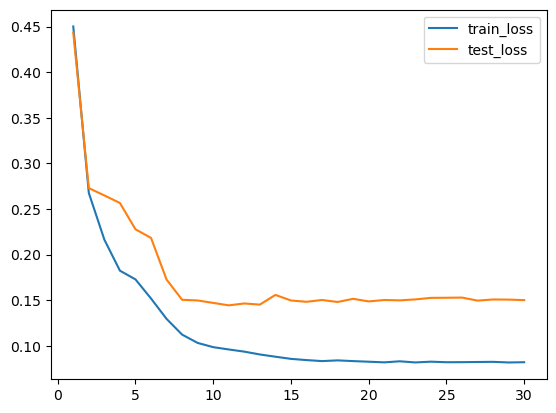

In [18]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

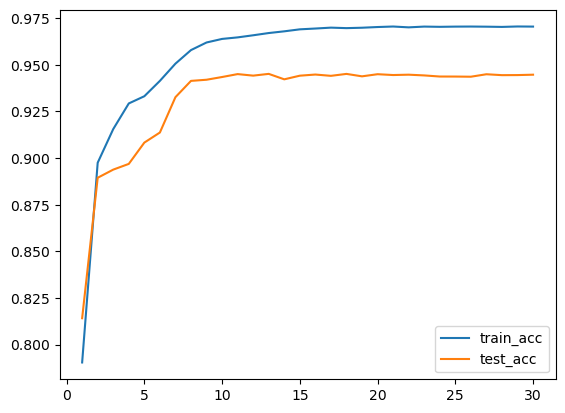

In [19]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()

# 测试模型

In [20]:
# 重新实例化并加载模型
model = LinkNet()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

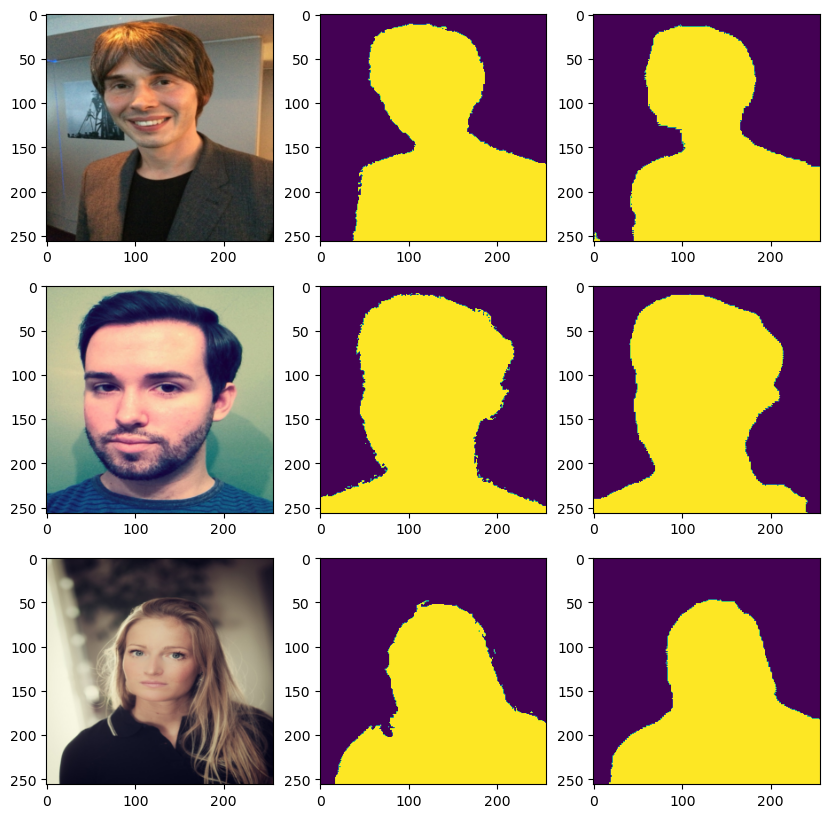

In [21]:
# 在测试数据上测试
num=3
image, mask = next(iter(test_dl))
pred_mask = model(image)

plt.figure(figsize=(10, 10))

# 依次绘制子图
for i in range(num):
    # 绘制原始图像
    plt.subplot(num, 3, i*num+1)
    plt.imshow(image[i].permute(1,2,0).cpu().numpy())
    # 绘制标签
    plt.subplot(num, 3, i*num+2)
    plt.imshow(mask[i].cpu().numpy())
    # 绘制预测结果
    plt.subplot(num, 3, i*num+3)
    plt.imshow(torch.argmax(pred_mask[i].permute(1,2,0), axis=-1).detach().numpy())     # argmax将预测结果转化为0和1的矩阵

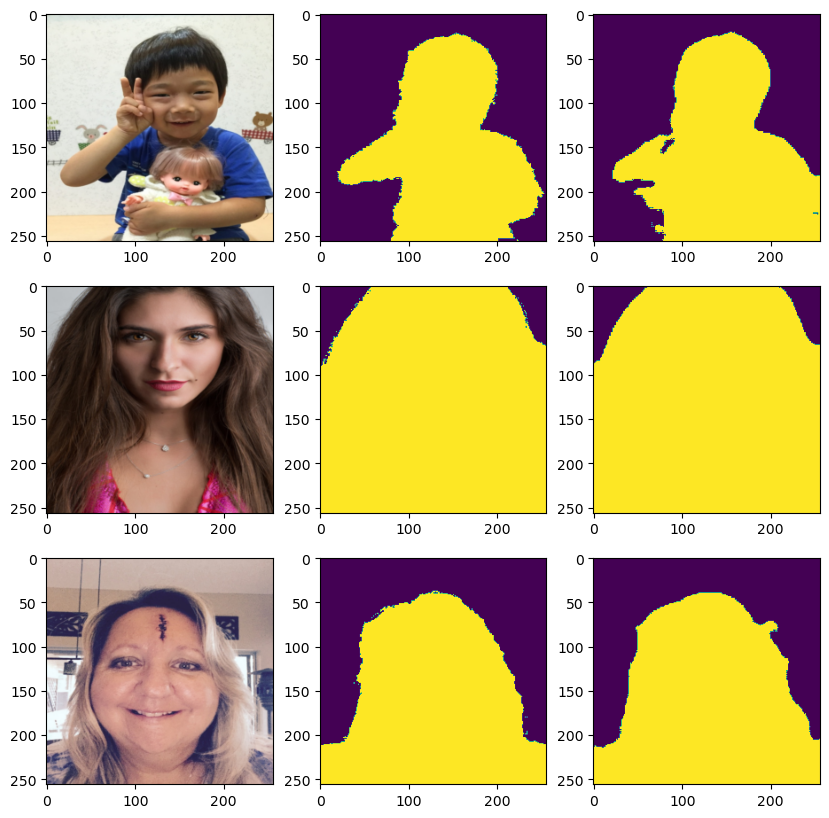

In [22]:
# 在训练数据上测试
image, mask = next(iter(train_dl))
pred_mask = model(image)

plt.figure(figsize=(10, 10))

# 依次绘制子图
for i in range(num):
    # 绘制原始图像
    plt.subplot(num, 3, i*num+1)
    plt.imshow(image[i].permute(1,2,0).cpu().numpy())
    # 绘制标签
    plt.subplot(num, 3, i*num+2)
    plt.imshow(mask[i].cpu().numpy())
    # 绘制预测结果
    plt.subplot(num, 3, i*num+3)
    plt.imshow(torch.argmax(pred_mask[i].permute(1,2,0), axis=-1).detach().numpy())     # argmax将预测结果转化为0和1的矩阵